In [1]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertModel



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [2]:
data_dir = "../../../data/twitter-distaster/"

In [3]:
train_df = pd.read_csv(f"{data_dir}/train.csv")
test_df = pd.read_csv(f"{data_dir}/test.csv")
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [4]:
val_df = train_df[51:70]
train_df = train_df[0:50]


In [77]:
val_df

,id,keyword,location,text,target
51,74,ablaze,India,Man wife get six years jail for setting ablaze...,1
52,76,ablaze,Barbados,SANTA CRUZ ÛÓ Head of the St Elizabeth Police...,0
53,77,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church...,1
54,78,ablaze,Abuja,Noches El-Bestia '@Alexis_Sanchez: happy to se...,0
55,79,ablaze,USA,#Kurds trampling on Turkmen flag later set it ...,1
56,80,ablaze,South Africa,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...,1
57,81,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gif...,0
58,82,ablaze,hollywoodland,They sky was ablaze tonight in Los Angeles. I'...,0
59,83,ablaze,"Edmonton, Alberta - Treaty 6",How the West was burned: Thousands of wildfire...,1
60,85,ablaze,NaN,Revel in yours wmv videos by means of mac fare...,0


<AxesSubplot:>

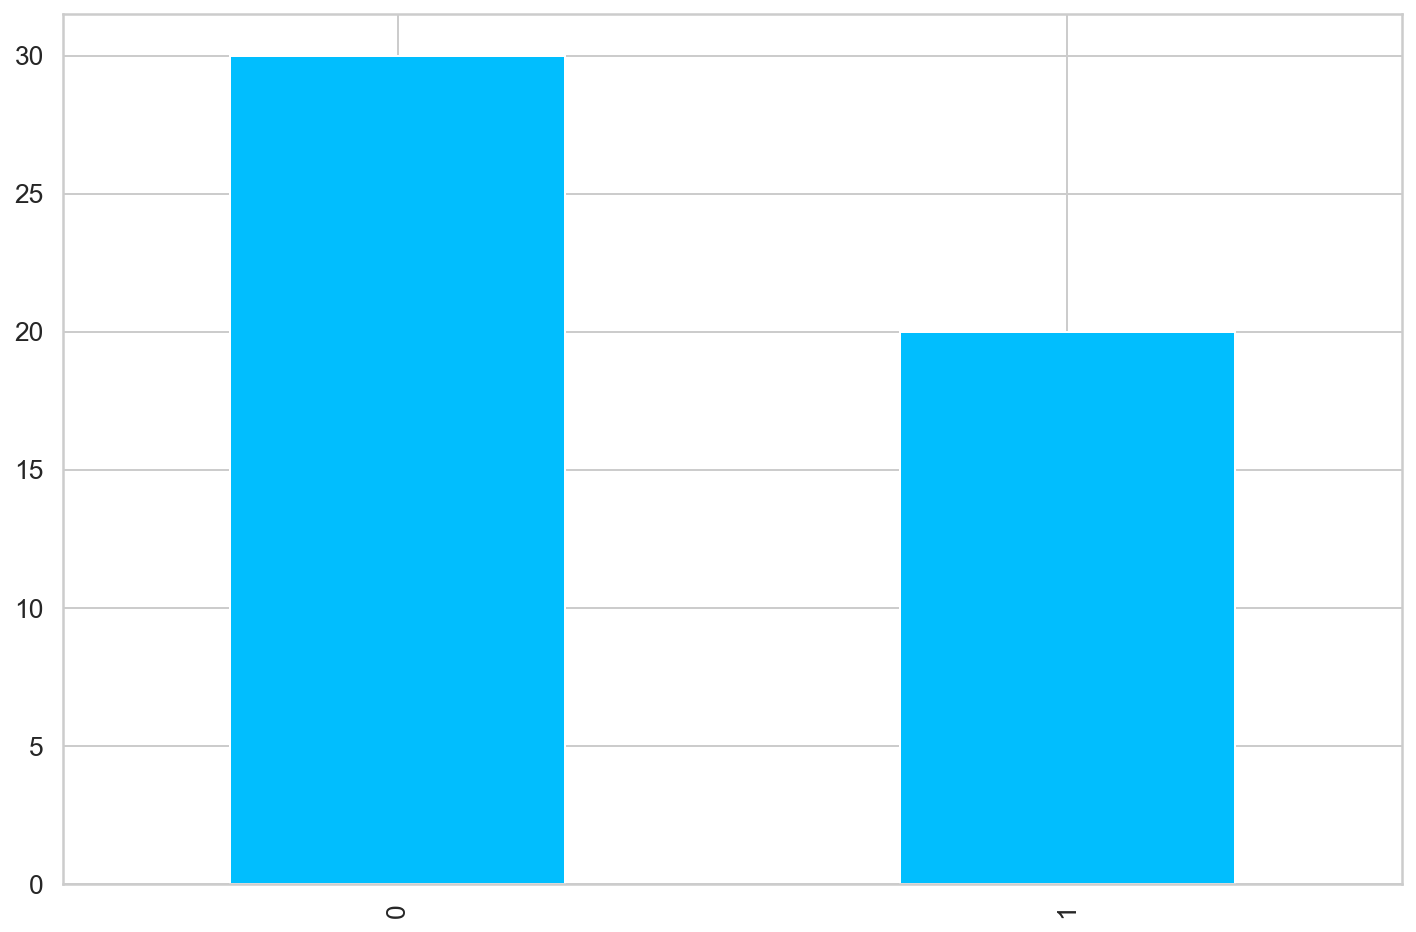

In [30]:
train_df.target.value_counts().plot(kind="bar")

In [5]:
BERT_MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [6]:
class TwitterDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 512,
    text_col: str = "text",
    label_col: str = "target"
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    self.text_col = text_col
    self.label_col = label_col
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row[self.text_col]
    labels = data_row[self.label_col]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.tensor(labels)
    )

In [88]:
train_dataset = TwitterDataset(
  train_df,
  tokenizer,
  max_token_len=512
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [89]:
sample_item["comment_text"]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [90]:
sample_item["labels"]

tensor(1)

In [87]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
class TwitterDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=2, max_token_len=512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = TwitterDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = TwitterDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )

In [8]:
N_EPOCHS = 10
BATCH_SIZE = 2
MAX_TOKEN_COUNT = 512
data_module = TwitterDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

AttributeError: 'TwitterDataModule' object has no attribute 'test_dataset'

In [18]:
class TwitterClassifier(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()

    self.save_hyperparameters()
    self.bert = DistilBertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    last_hidden_state = output.last_hidden_state
    # As I said, the CLS token is in the beginning of the sequence. So, we grab its representation 
    # by indexing the tensor containing the hidden representations
    CLS_token_state = last_hidden_state[:, 0, :]
    output = self.classifier(CLS_token_state)
           
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    softmax = nn.functional.softmax
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        out_predictions = softmax(out_predictions)
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    class_roc_auc = auroc(predictions, labels, num_classes=2)
    self.logger.experiment.add_scalar(f"roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [10]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [11]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(50, 250)

In [19]:
model = TwitterClassifier(
  n_classes=2,
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints/twitterdisaster/",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

C:\Users\ntaylor\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\distributed.py:68: UserWarning: Checkpoint directory checkpoints/twitterdisaster/ exists and is not empty.
  warnings.warn(*args, **kwargs)


In [14]:
logger = TensorBoardLogger("lightning_logs", name="twitter-disaster")

In [15]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [21]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1
  
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [22]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | DistilBertModel  | 65.2 M
1 | classifier | Linear           | 1.5 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.770   Total estimated model params size (MB)


Epoch 0:  71%|███████▏  | 25/35 [00:06<00:02,  3.66it/s, loss=0.754, v_num=3, val_loss=0.741, train_loss=0.739]

C:\Users\ntaylor\AppData\Local\Temp/ipykernel_26868/1777781792.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_predictions = softmax(out_predictions)


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.62it/s, loss=0.754, v_num=3, val_loss=0.688, train_loss=0.772]

Epoch 0, global step 24: val_loss reached 0.68793 (best 0.68793), saving model to "C:\Users\ntaylor\Documents\GitHub\Neural_Networks\NLP_Mimic_only\pytorch-lightning-models\checkpoints\twitterdisaster\best-checkpoint-v2.ckpt" as top 1


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.62it/s, loss=0.63, v_num=3, val_loss=0.609, train_loss=0.637]

Epoch 1, global step 49: val_loss reached 0.60874 (best 0.60874), saving model to "C:\Users\ntaylor\Documents\GitHub\Neural_Networks\NLP_Mimic_only\pytorch-lightning-models\checkpoints\twitterdisaster\best-checkpoint-v2.ckpt" as top 1


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.60it/s, loss=0.207, v_num=3, val_loss=0.428, train_loss=0.570] 

Epoch 2, global step 74: val_loss reached 0.42750 (best 0.42750), saving model to "C:\Users\ntaylor\Documents\GitHub\Neural_Networks\NLP_Mimic_only\pytorch-lightning-models\checkpoints\twitterdisaster\best-checkpoint-v2.ckpt" as top 1


Epoch 3: 100%|██████████| 35/35 [00:07<00:00,  4.56it/s, loss=0.105, v_num=3, val_loss=0.433, train_loss=0.00374]

Epoch 3, step 99: val_loss was not in top 1


Epoch 4: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s, loss=0.0221, v_num=3, val_loss=0.512, train_loss=0.00777]

Epoch 4, step 124: val_loss was not in top 1


Epoch 4: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s, loss=0.0221, v_num=3, val_loss=0.512, train_loss=0.00777]


1